# Задача 3: Проверка гипотез
**Главная страница Яндекса.** Поменяли местами иконки "Маркет" и "Карты" над строкой поиска. Необходимо проверить повлияло ли изменение и стали ли пользователи чаще кликать на иконку "Маркета" по возвращению на сайт

Формула кликабельности иконки маркета

$$\text{CTR} = \frac{\sum_{c_{i} \in C} \text{Clicks }}{\sum_{s_{i} \in S} \text{Sessions } }$$

### Описание колонок

- `user_id` – идентификатор пользователя
- `session_id` – идентификатор сессии
- `click_id` – идентификатор клика
- `experimentVariant` – вариант эксперимента

### Задача

1. Проверьте гипотезу о кликабельности иконки с помощью метрики CTR (click-through-rate)
2. Напишите выводы, которые можно сделать на основе анализа результатов

## Загрузка и изучение датасета

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('case_ctr.csv', index_col = 'Unnamed: 0', sep = ';')

In [3]:
data.head()

,user_id,session_id,click_id,experimentVariant
1,4299b8c9c50c3e4e8a067f448426463e,08f9c3b0e2ff8da7bad6cc200fa735a2,56bcee80ce68ddc58c178a63288965b2,1
2,863829e0fc8e0dcd88f44c6a63db836a,d0ebf6ddaa8702e6de4e46854a1136ff,b209c6b14e91606a99d637ff6eb74cc6,1
3,640af3312483bea44b8159a8caaf0b3d,838c4a718830b5f1ac7be5e70745ff47,3f3d510c709ae5d9bae0331fcf776f3a,1
4,43de481cae63944b81db6fd5567a12bb,8f36aead1ceafb3e67f9957a7765549e,da73306047217a73a6ee0ea7477f2ad7,0
5,b84dd1a6c3df2e08eb7bef496cdf6d39,09799cdf1394b0e4b86ace899b7f218e,6e4b93932be600a5536c291888996037,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            10000 non-null  object
 1   session_id         10000 non-null  object
 2   click_id           7655 non-null   object
 3   experimentVariant  10000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 390.6+ KB


Имеем идентификаторы пользоватлей, сессий и кликов, разбивку на тестовую и контрольную группы. Всего 10000 строк, часть значений колонки click_id обозначена NaN. Проведем исследовательский анализ и проверим верность разделения пользователй на группы. 

## Исследовательский анализ данных

Сгруппируем сессии и клики пользователей, посмотрим топ значений

In [5]:
user_session_gb = data.groupby('user_id', as_index = False)\
                                .agg({'session_id': 'count',
                                     'click_id': 'count',
                                     'experimentVariant': 'first'})

In [6]:
user_session_gb.sort_values('click_id', ascending = False).head(10)

,user_id,session_id,click_id,experimentVariant
602,45f8c7d7bd3f733e7d75b74ae816aace,13,12,1
1345,9b5c0c541c2b13e6704e77281730e6f5,12,12,1
911,661c984151d8ac7ce7a9f63f5b9ef4ca,12,11,0
1443,a6753c12d498865de282559114c1a0c7,11,11,1
328,295da1d8d9887942fea0abba07121991,11,11,0
1563,b142f1491ca9555d60503685e333030d,12,11,0
1729,c5b28eefd597185ff31411971d46d2ce,13,11,1
1794,cd0160d26293652422e9641f9ff43973,12,10,0
1717,c3521fa486d0aeff3175ddf78f3bdb30,11,10,0
229,1c8aa245ea2d463c2cd57440de5b6ba5,10,10,0


In [7]:
user_session_gb.session_id.describe()

count    2246.000000
mean        4.452360
std         2.250504
min         1.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        13.000000
Name: session_id, dtype: float64

In [8]:
user_session_gb.click_id.describe()

count    2246.000000
mean        3.408281
std         1.956385
min         0.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        12.000000
Name: click_id, dtype: float64

Визуально не наблюдаем явных выбросов или перекоса в одной из групп, посмотрим на рапределения. 

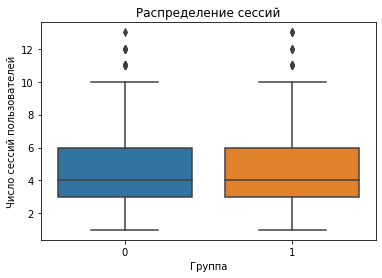

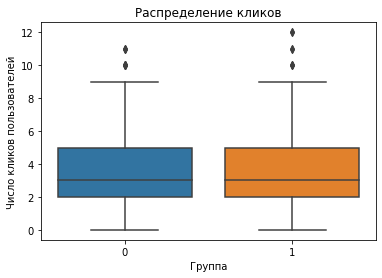

In [9]:
sns.boxplot(data = user_session_gb, x = 'experimentVariant', y = 'session_id')
plt.title('Распределение сессий')
plt.xlabel('Группа')
plt.ylabel('Число сессий пользователей')
plt.show()
sns.boxplot(data = user_session_gb, x = 'experimentVariant', y = 'click_id')
plt.title('Распределение кликов')
plt.xlabel('Группа')
plt.ylabel('Число кликов пользователей')
plt.show()

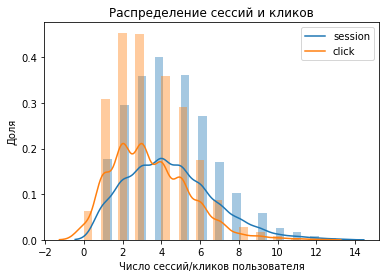

In [10]:
sns.distplot(user_session_gb.session_id)
sns.distplot(user_session_gb.click_id)
plt.legend(['session', 'click'])
plt.title('Распределение сессий и кликов')
plt.xlabel('Число сессий/кликов пользователя')
plt.ylabel('Доля')
plt.show()

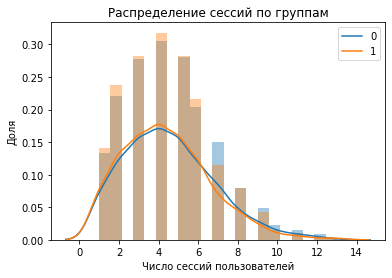

In [11]:
sns.distplot(user_session_gb.query('experimentVariant==0').session_id)
sns.distplot(user_session_gb.query('experimentVariant==1').session_id)
plt.legend([0, 1])
plt.title('Распределение сессий по группам')
plt.xlabel('Число сессий пользователей')
plt.ylabel('Доля')
plt.show()

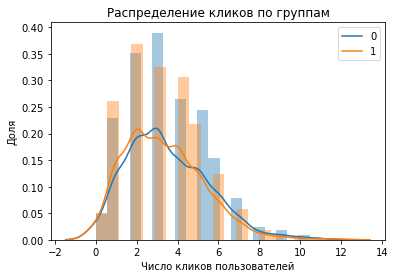

In [12]:
sns.distplot(user_session_gb.query('experimentVariant==0').click_id)
sns.distplot(user_session_gb.query('experimentVariant==1').click_id)
plt.legend([0, 1])
plt.title('Распределение кликов по группам')
plt.xlabel('Число кликов пользователей')
plt.ylabel('Доля')
plt.show()

Отфильтруем значения выше верхней границы

In [13]:
user_session_gb.query('session_id > 10 | click_id > 9')['experimentVariant'].value_counts()

0    19
1    14
Name: experimentVariant, dtype: int64

In [14]:
users_blowout = set(user_session_gb.query('session_id > 10 | click_id > 9').user_id)
data_clean = data[data.user_id.isin(list(set(data.user_id) ^ users_blowout))]

In [15]:
print('Мы удалили {:.2%} строк'.format(1 - len(data_clean) / len(data)))

Мы удалили 3.77% строк


In [16]:
group_a = data_clean.query('experimentVariant==0')
group_b = data_clean.query('experimentVariant==1')

Разделили группы, проверим пересечения пользователей и размеры выборок в группах. 

In [17]:
print('Число пользователей, входящих в обе группы -', \
      len(set(group_a.user_id.unique()) & set(group_b.user_id.unique())))

Число пользователей, входящих в обе группы - 0


In [18]:
print('В группе A {} пользователей - {:.2f}% выборки' \
      .format(len(group_a.user_id.unique()),\
              len(group_a.user_id.unique())/len(data_clean.user_id.unique())*100))
print('В группе B {} пользователей - {:.2f}% выборки' \
      .format(len(group_b.user_id.unique()),\
              len(group_b.user_id.unique())/len(data_clean.user_id.unique())*100))

В группе A 1110 пользователей - 50.16% выборки
В группе B 1103 пользователей - 49.84% выборки


In [19]:
print('В группе A {} сессий - {:.2f}% выборки' \
      .format(len(group_a.session_id),\
              len(group_a.session_id)/len(data_clean.user_id)*100))
print('В группе B {} сессий - {:.2f}% выборки' \
      .format(len(group_b.session_id),\
              len(group_b.session_id)/len(data_clean.user_id)*100))

В группе A 4897 сессий - 50.89% выборки
В группе B 4726 сессий - 49.11% выборки


Посчитаем кумулятивные клики и конверсии в группах

In [20]:
# перекодируем идентификаторы для удобства подсчета
encoder = lambda x: 0 if x != x else 1
group_a.session_id = group_a.session_id.apply(encoder)
group_a.click_id = group_a.click_id.apply(encoder)

group_b.session_id = group_b.session_id.apply(encoder)
group_b.click_id = group_b.click_id.apply(encoder)

In [21]:
group_a['cum_session'] = group_a.session_id.cumsum()
group_a['cum_click'] = group_a.click_id.cumsum()
group_a['ctr'] = group_a['cum_click'] / group_a['cum_session']

group_b['cum_session'] = group_b.session_id.cumsum()
group_b['cum_click'] = group_b.click_id.cumsum()
group_b['ctr'] = group_b['cum_click'] / group_b['cum_session']

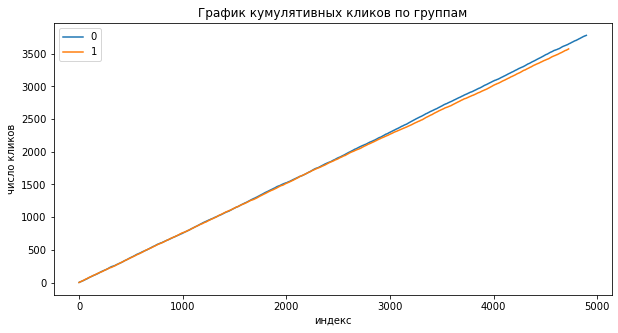

In [22]:
plt.figure(figsize=(10, 5))
sns.lineplot(x = range(len(group_a)), y = group_a['cum_click'])
sns.lineplot(x = range(len(group_b)), y = group_b['cum_click'])
plt.title('График кумулятивных кликов по группам')
plt.ylabel('число кликов')
plt.xlabel('индекс')
plt.legend([0,1])

Text(0.5, 0, 'индекс')

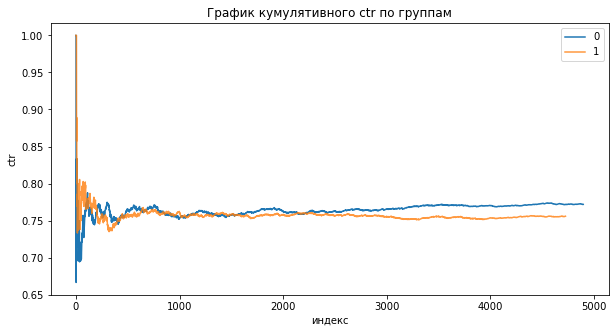

In [23]:
plt.figure(figsize=(10, 5))
sns.lineplot(x = range(len(group_a)), y = group_a['ctr'])
sns.lineplot(x = range(len(group_b)), y = group_b['ctr'], alpha  = 0.8)
plt.title('График кумулятивного ctr по группам')
plt.legend([0,1])
plt.ylabel('ctr')
plt.xlabel('индекс')

Мы изучили распределение сессий и кликов, распределния в разбивке групп. Группы имеют похожие распределения. Отфильтровали значения по верхней границе, удалили 3.77% выборки для получения качественного результата. Группы не имеют пересечения по пользователям, выборка разделена пополам на тестовую и контрольную группы. 

## Анализ результатов эксперимента

Проверим данные на нормальность распределения, ипользуя тест Шапиро-Уилка.   
H0 - данные распределены нормально  
H1 - данные не подчиняются нормальному распределению  

In [24]:
print('p_value A Shapiro–Wilk: {:.2f}'.format(st.shapiro(group_a.click_id)[1]))
print('p_value A Shapiro–Wilk: {:.2f}'.format(st.shapiro(group_b.click_id)[1]))

p_value A Shapiro–Wilk: 0.00
p_value A Shapiro–Wilk: 0.00


P значение меньше уровня значимость 0.05, отклоняем нулевую гипотезу, данные не подчиняются закону нормального распределения.

Гипотеза H0 - CTR групп равны  
Альтернативная гипотеза H1 - CTR групп не равны

Имеем независимые выборки, данные не подчиняются закону нормального распределния, для проверки гипотезы будем использовать непараметрический Критерий Манна-Уитни.

In [25]:
print('p_value: {:.5f}'.format(
    st.mannwhitneyu(group_a.click_id, group_b.click_id,
            alternative = 'two-sided')[1]))
print('CTR группы A = {:.2f}'.format(group_a.click_id.sum() / group_a.session_id.sum()))
print('CTR группы B = {:.2f}'.format(group_b.click_id.sum() / group_b.session_id.sum()))

print('Относительные различия в CTR: {0:.3f}' \
      .format((group_a.click_id.sum() / group_a.session_id.sum()) / 
              (group_b.click_id.sum() / group_b.session_id.sum())-1))

p_value: 0.06678
CTR группы A = 0.77
CTR группы B = 0.76
Относительные различия в CTR: 0.021


Так как p значение больше уровня значимости 0.05, гипотеза H0 не отвергается, CTR групп равны. Изменения не повляили на клики иконки маркета. 

### Вывод

Мы изучили распределение сессий и кликов, распределния в разбивке групп. Группы имеют похожие распределения. Отфильтровали значения по верхней границе, удалили экстремальные 3.77% выборки для получения качественного результата. Группы не имеют пересечения по пользователям, выборка разделена пополам на тестовую и контрольную группы. На одного пользователя приходится медианно 4 сессии и 3 клика на иконку.

Используя критерий Манна-Уитни проверили гипотезу о кликабельности иконки с помощью метрики CTR (группа 0 - 0.77, группа 1 - 0.076). CTR тестовой и контрольной группы статистически неразличимы, изменения не повлияли на клики иконки маркета. 

Изменение мест маркета и карт не привело к увеличению кликов на маркет, если мы хотим добиться увеличения сtr посредством сзменения положения сервиса на главной странце, то можем запустить эксперимент и подвинуть маркет в начало бара иконок, либо протестировать отдельный виджет. 